## Self RAG

Research paper - https://arxiv.org/abs/2310.11511


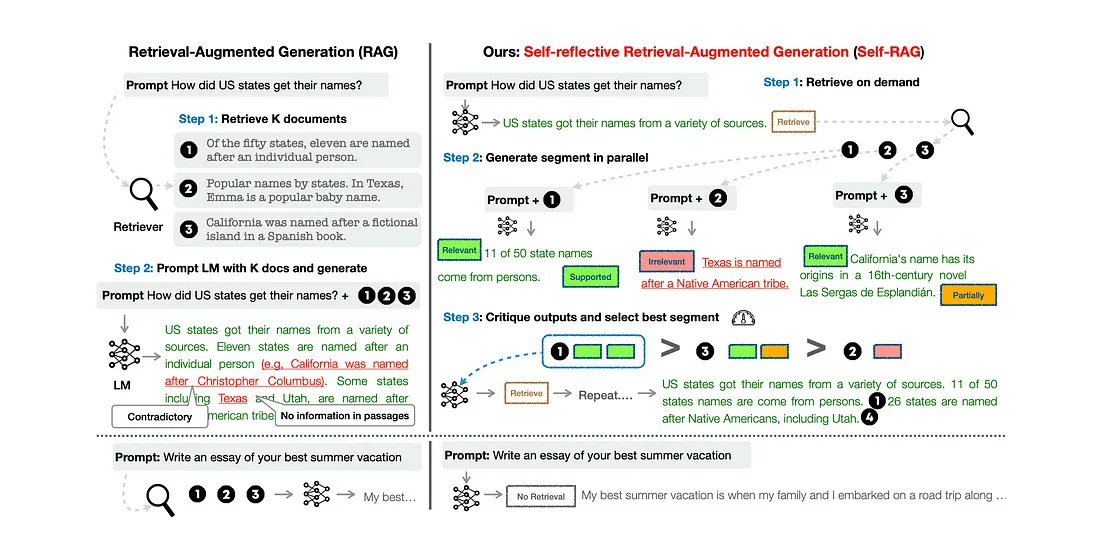

Self-RAG allows the model to **retrieve relevant documents** autonomously and iteratively during the generation process, optimizing the relevance of the retrieved information without external supervision.

The key difference between Self-RAG and traditional RAG approaches is that Self-RAG autonomously decides when and what to retrieve, continuously refining the retrieval process in multiple steps to improve the answer's quality. This process integrates both retrieval and generation in a loop where the model, while generating text, retrieves additional context from external sources and refines its answers accordingly.

### Splitting the PDF file

In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

file_path = "../data/who_stats_2022.pdf"

loader = PyPDFLoader(file_path=file_path)
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=500,
    chunk_overlap=100,
)

pdf_pages = loader.load_and_split(text_splitter=text_splitter)


### Load env variables which has hugging face API token

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

hugging_face_api_key = os.environ["HUGGINGFACEHUB_API_TOKEN"]
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

### Create vector database using chroma

In [5]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_chroma import Chroma

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
persist_dir = "chromadb"
db = Chroma.from_documents(documents=pdf_pages, embedding=embedding_function, )

d:\VS Code\python\GenAI-Cookbook\venv\Lib\site-packages\langchain_community\embeddings\sentence_transformer.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
C:\Users\VARUN ARORA\AppData\Local\Temp\ipykernel_9520\1398795754.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingfa

In [25]:
%pip install -q langchain-groq

Note: you may need to restart the kernel to use updated packages.


In [2]:
# were facing problems with Gemini for structured outputs

import os
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama3-70b-8192",
    api_key=os.environ['GROQ_API_KEY'], # .env file has the API key
    temperature=0.5
)


In [6]:
llm.invoke("What is capital of India?")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 16, 'total_tokens': 25, 'completion_time': 0.028893243, 'prompt_time': 0.000304637, 'queue_time': 0.015115275, 'total_time': 0.02919788}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_87cbfbbc4d', 'finish_reason': 'stop', 'logprobs': None}, id='run-6411c5b2-138e-460f-b89e-a8bab7a222aa-0', usage_metadata={'input_tokens': 16, 'output_tokens': 9, 'total_tokens': 25})

In [7]:
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate

# the 3 dots "..." in pydantic indicate that the fields are REQUIRED and are called the "ellipsis"

class RetrievalResponse(BaseModel):
    response: str = Field(..., title="Determines if retrieval is necessary", description="Output only 'Yes' or 'No'.")
retrieval_prompt = PromptTemplate(
    input_variables=["query"],
    template="Given the query '{query}', determine if retrieval is necessary. Output only 'Yes' or 'No'."
)

class RelevanceResponse(BaseModel):
    response: str = Field(..., title="Determines if context is relevant", description="Output only 'Relevant' or 'Irrelevant'.")
relevance_prompt = PromptTemplate(
    input_variables=["query", "context"],
    template="Given the query '{query}' and the context '{context}', determine if the context is relevant. Output only 'Relevant' or 'Irrelevant'."
)

class GenerationResponse(BaseModel):
    response: str = Field(..., title="Generated response", description="The generated response.")
generation_prompt = PromptTemplate(
    input_variables=["query", "context"],
    template="Given the query '{query}' and the context '{context}', generate a response."
)

class SupportResponse(BaseModel):
    response: str = Field(..., title="Determines if response is supported", description="Output 'Fully supported', 'Partially supported', or 'No support'.")
support_prompt = PromptTemplate(
    input_variables=["response", "context"],
    template="Given the response '{response}' and the context '{context}', determine if the response is supported by the context. Output 'Fully supported', 'Partially supported', or 'No support'."
)

class UtilityResponse(BaseModel):
    response: int = Field(..., title="Utility rating", description="Rate the utility of the response from 1 to 5.")
utility_prompt = PromptTemplate(
    input_variables=["query", "response"],
    template="Given the query '{query}' and the response '{response}', rate the utility of the response from 1 to 5."
)

# Create LLMChains for each step
retrieval_chain = retrieval_prompt | llm.with_structured_output(RetrievalResponse)
relevance_chain = relevance_prompt | llm.with_structured_output(RelevanceResponse)
generation_chain = generation_prompt | llm.with_structured_output(GenerationResponse)
support_chain = support_prompt | llm.with_structured_output(SupportResponse)
utility_chain = utility_prompt | llm.with_structured_output(UtilityResponse)

In [8]:
def self_rag(query, vectorstore, top_k=3):
    print(f"\nProcessing query: {query}")
    
    # Step 1: Determine if retrieval is necessary
    print("Step 1: Determining if retrieval is necessary...")
    input_data = {"query": query}
    retrieval_decision = retrieval_chain.invoke(input_data).response.strip().lower()
    print(f"Retrieval decision: {retrieval_decision}")
    
    if retrieval_decision == 'yes':
        # Step 2: Retrieve relevant documents
        print("Step 2: Retrieving relevant documents...")
        docs = vectorstore.similarity_search(query, k=top_k)
        contexts = [doc.page_content for doc in docs]
        print(f"Retrieved {len(contexts)} documents")
        
        # Step 3: Evaluate relevance of retrieved documents
        print("Step 3: Evaluating relevance of retrieved documents...")
        relevant_contexts = []
        for i, context in enumerate(contexts):
            input_data = {"query": query, "context": context}
            relevance = relevance_chain.invoke(input_data).response.strip().lower()
            print(f"Document {i+1} relevance: {relevance}")
            if relevance == 'relevant':
                relevant_contexts.append(context)
        
        print(f"Number of relevant contexts: {len(relevant_contexts)}")
        
        # If no relevant contexts found, generate without retrieval
        if not relevant_contexts:
            print("No relevant contexts found. Generating without retrieval...")
            input_data = {"query": query, "context": "No relevant context found."}
            return generation_chain.invoke(input_data).response
        
        # Step 4: Generate response using relevant contexts
        print("Step 4: Generating responses using relevant contexts...")
        responses = []
        for i, context in enumerate(relevant_contexts):
            print(f"Generating response for context {i+1}...")
            input_data = {"query": query, "context": context}
            response = generation_chain.invoke(input_data).response
            
            # Step 5: Assess support
            print(f"Step 5: Assessing support for response {i+1}...")
            input_data = {"response": response, "context": context}
            support = support_chain.invoke(input_data).response.strip().lower()
            print(f"Support assessment: {support}")
            
            # Step 6: Evaluate utility
            print(f"Step 6: Evaluating utility for response {i+1}...")
            input_data = {"query": query, "response": response}
            utility = int(utility_chain.invoke(input_data).response)
            print(f"Utility score: {utility}")
            
            responses.append((response, support, utility))
        
        # Select the best response based on support and utility
        print("Selecting the best response...")
        best_response = max(responses, key=lambda x: (x[1] == 'fully supported', x[2]))
        print(f"Best response support: {best_response[1]}, utility: {best_response[2]}")
        return best_response[0]
    else:
        # Generate without retrieval
        print("Generating without retrieval...")
        input_data = {"query": query, "context": "No retrieval necessary."}
        return generation_chain.invoke(input_data).response

In [9]:
query = "What is the impact of climate change on the environment?"
response = self_rag(query, db)

print("\nFinal response:")
print(response)


Processing query: What is the impact of climate change on the environment?
Step 1: Determining if retrieval is necessary...
Retrieval decision: yes
Step 2: Retrieving relevant documents...
Retrieved 3 documents
Step 3: Evaluating relevance of retrieved documents...
Document 1 relevance: relevant
Document 2 relevance: irrelevant
Document 3 relevance: relevant
Number of relevant contexts: 2
Step 4: Generating responses using relevant contexts...
Generating response for context 1...
Step 5: Assessing support for response 1...
Support assessment: fully supported
Step 6: Evaluating utility for response 1...
Utility score: 5
Generating response for context 2...
Step 5: Assessing support for response 2...
Support assessment: fully supported
Step 6: Evaluating utility for response 2...
Utility score: 5
Selecting the best response...
Best response support: fully supported, utility: 5

Final response:
Climate change has far-reaching consequences on the environment, including rising global tempe

In [13]:
retrieval_chain.invoke(query)

### Conclusion

While the above methods called as steps were much more abstract as compared to real world scenarios, these methods can be used in to get better quality responses. Realistically, we can have Validation function before chain call => Relevant docs retrieval chain => docs filtering => generation chain.

As the number of chains increase linearly, so does time taken to call, making it time consuming for a real world API